In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import matplotlib.colors
from tqdm import tqdm

## Plot Config

In [2]:
dataset_names = {
    "german" : "German Credit",
    "compas" : "COMPAS",
    "adult" : "Adult",
    "acsincome" : "ACSIncome",
    "taiwan" : "Taiwan Credit",
    "enem" : "ENEM",
    "enemreg" : "ENEM Reg.",
}
methods_color = {
    "LGBMClassifier" : "#ffd92f",
    "LGBMRegressor" : "#ffd92f",
    "FairGBMClassifier" : "#fc8d62",
    "FairGBMClassifier_eod" : "#fc8d62",
    "MinMaxFair" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "MinMaxFair_tpr" : "#a6d854",
    "MinMaxFairRegressor" : "#a6d854",
    "M2FGBClassifier" : "#8da0cb",
    "M2FGBClassifier_v1" : "#8da0cb",
    "M2FGBClassifier_tpr" : "#8da0cb",
    "M2FGBClassifier_v1_tpr" : "#8da0cb",
    "M2FGBClassifier_pr" : "#8da0cb",
    "M2FGBClassifier_v1_pr" : "#8da0cb",
    "M2FGBRegressor" : "#8da0cb",
    "MinimaxPareto" : "pink",
    "MinimaxPareto_tpr" : "pink"
}
methods_names = {
    "LGBMClassifier" : "LGBM",
    "LGBMRegressor" : "LGBM",
    "FairGBMClassifier" : "FairGBM",
    "FairGBMClassifier_eod" : "FairGBM (eod)",
    "M2FGBClassifier_tpr" : "M²FGB (tpr)",
    "M2FGBClassifier_pr" : "M²FGB (pr)",
    "M2FGBClassifier" : "M²FGB",
    "M2FGBRegressor" : "M²FGB",
    "MinMaxFair" : "MinMaxFair",
    "MinMaxFair_tpr" : "MinMaxFair (tpr)",
    "MinimaxPareto" : "MMPF",
    "MinimaxPareto_tpr" : "MMPF (tpr)",
    "MinMaxFairRegressor" : "MinMaxFair",
}

handles = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" not in key and "pr" not in key and "eod" not in key
]

handles_tpr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "tpr" in key or "LGBMClassifier" in key or "eod" in key
]
handles_eq = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if key in ["LGBMClassifier", "M2FGBClassifier", "MinimaxPareto", "MinMaxFairRegressor", "FairGBMClassifier"]
]


handles_pr = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "_pr" in key or "LGBMClassifier" in key
]

handles_reg = [
    Line2D([0], [0], marker = "o", color = "w", label=value, markerfacecolor=methods_color[key], markersize=10) for key, value in methods_names.items() if "Regressor" in key
]

In [3]:
SEED = 0
np.random.seed(SEED)

## Convergence Plots

In [4]:
import sys
sys.path.append("../scripts")
import data
import models
import utils

from sklearn.metrics import accuracy_score, log_loss

%load_ext autoreload
%autoreload 2

In [5]:
args = {
    "dataset" : "enem",
    "n_groups" : 8,
}
X_train, A_train, Y_train, X_val, A_val, Y_val, X_test, A_test, Y_test = (
    data.get_strat_split(args["dataset"], args["n_groups"], 20, SEED)
)

{'Brown, Male': 0, 'Black, Female': 1, 'White, Female': 2, 'Other, Female': 3, 'Brown, Female': 4, 'Black, Male': 5, 'White, Male': 6, 'Other, Male': 7}


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


In [6]:
params = {
    "learning_rate" : 0.1,
    "multiplier_learning_rate" : 0.01,
}

In [21]:
def call_model(iter, method):
    if method == "m2fgb":
        return models.M2FGBClassifier(
            fair_weight=0.5,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            dual_learning="gradient_norm",
            random_state=SEED,
            **params
        )
    elif method == "lgbm":
        return models.M2FGBClassifier(
            fair_weight=0,
            n_estimators=iter,
            fairness_constraint="true_positive_rate",
            dual_learning="gradient_norm",
            random_state=SEED,
            **params
        )


iters_list = list(range(3, 100, 3))
methods_names = ["lgbm", "m2fgb"]

results = []

models_dict = {}
for method in methods_names:
    model = call_model(max(iters_list), method)
    model.fit(X_train, Y_train, A_train)
    models_dict[method] = model

    for iter in tqdm(iters_list):
        Y_pred = model.predict_proba(X_train, num_iteration=iter)[:, 1]
        loss = -(Y_train * np.log(Y_pred) + (1 - Y_train) * np.log(1 - Y_pred))
        Y_pred = Y_pred > 0.5

        results.append({
            "set" : "train",
            "method" : method,
            "iter" : iter,
            "acc" : accuracy_score(Y_train, Y_pred),
            "tpr" : utils.tpr_score(Y_train, Y_pred),
            "logloss" : np.nanmean(loss),
            "tpr_logloss" : np.nanmean(loss[Y_train == 1]),
        })

        for a in sorted(A_train.unique().tolist()): #A_train.unique():
            idx = A_train == a
            results[-1]["acc_" + str(a)] = accuracy_score(Y_train[idx], Y_pred[idx])
            results[-1]["tpr_" + str(a)] = utils.tpr_score(Y_train[idx], Y_pred[idx])
            results[-1]["logloss_" + str(a)] = np.nanmean(loss[idx])
            results[-1]["tpr_logloss_" + str(a)] = np.nanmean(loss[idx][Y_train[idx] == 1])

        Y_pred = model.predict_proba(X_test, num_iteration=iter)[:, 1]
        loss = -(Y_test * np.log(Y_pred) + (1 - Y_test) * np.log(1 - Y_pred))
        Y_pred = Y_pred > 0.5

        results.append({
            "set" : "test",
            "method" : method,
            "iter" : iter,
            "acc" : accuracy_score(Y_test, Y_pred),
            "tpr" : utils.tpr_score(Y_test, Y_pred),
            "logloss" : np.nanmean(loss),
            "tpr_logloss" : np.nanmean(loss[Y_test == 1]),
        })

        for a in sorted(A_train.unique().tolist()): #A_train.unique():
            idx = A_test == a
            results[-1]["acc_" + str(a)] = accuracy_score(Y_test[idx], Y_pred[idx])
            results[-1]["tpr_" + str(a)] = utils.tpr_score(Y_test[idx], Y_pred[idx])
            results[-1]["logloss_" + str(a)] = np.nanmean(loss[idx])
            results[-1]["tpr_logloss_" + str(a)] = np.nanmean(loss[idx][Y_test[idx] == 1])

results = pd.DataFrame(results)

100%|████████████████████████████████████████████████████████████████████████████████████████████| 33/33 [00:04<00:00,  6.93it/s]


In [8]:
legend = {0: 'Brown, Male',
 1: 'Black, Female',
 2: 'White, Female',
 3: 'Other, Female',
 4: 'Brown, Female',
 5: 'Black, Male',
 6: 'White, Male',
 7: 'Other, Male'}

# get Set2 colors
from matplotlib.colors import rgb2hex
colors = plt.cm.Set2.colors
legend_colors = [rgb2hex(colors[i]) for i in range(8)]
legend_colors

{0: 'Brown, Male',
 1: 'Black, Female',
 2: 'White, Female',
 3: 'Other, Female',
 4: 'Brown, Female',
 5: 'Black, Male',
 6: 'White, Male',
 7: 'Other, Male'}

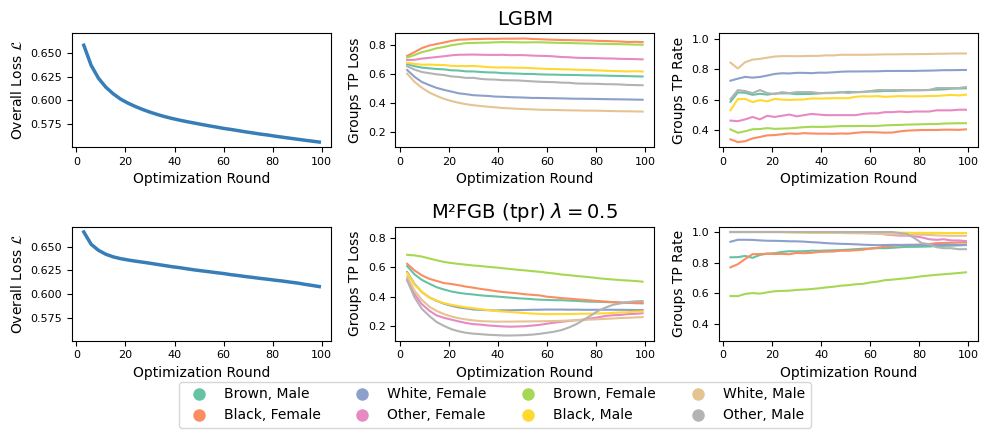

In [25]:
fig, axs = plt.subplots(nrows = 2, ncols = 3, figsize = (10, 4), sharey = "col")

better_methods_names = {
    "lgbm" : "$\mu$ fixed",
    "m2fgb" : "$\mu$ updating (M²FGB)"
}

for i, method in enumerate(methods_names):
    results_temp = results[(results["set"] == "train") & (results["method"] == method)]

    for j in range(3):
        axs[i, j].set_prop_cycle(color=plt.cm.Set2.colors)
        axs[i, j].set_xlabel("Optimization Round")
    
    axs[i, 0].plot(
        results_temp["iter"],
        results_temp["logloss"],
        c = "#377eb8",
        lw = 2.5,
    )


    for ng in range(args["n_groups"]):


        axs[i, 1].plot(
            results_temp["iter"],
            results_temp["tpr_logloss_" + str(ng)],
            #label = "Group " + str(ng),
            #marker = "o"
        )

        axs[i, 2].plot(
            results_temp["iter"],
            results_temp["tpr_" + str(ng)],
            #label = "Group " + str(ng),
            #marker = "o"
        )

    
        axs[i, 0].set_ylabel("Overall Loss $\mathcal{L}$")
        axs[i, 1].set_ylabel("Groups TP Loss")
        axs[i, 2].set_ylabel("Groups TP Rate")


axs[0, 1].set_title("LGBM", fontsize = 14)
axs[1, 1].set_title("M²FGB (tpr) $\lambda = 0.5$", fontsize = 14)

# reduce all axis ticks size
for ax in axs.flatten():
    ax.tick_params(axis='both', which='major', labelsize=8)

plt.tight_layout()

# add a legend 
handles_groups = [
    Line2D([0], [0], marker = "o", color = "w", label=legend[i], markerfacecolor=legend_colors[i], markersize=10) for i in range(8)
]

# move legend a little bit down
fig.legend(handles_groups, legend.values(), loc='upper center', bbox_to_anchor=(0.5, 0.05), ncol=4)
plt.savefig("../figs/convergence_enem_updated.pdf", dpi = 300)
plt.show()

## $\lambda$ parameter

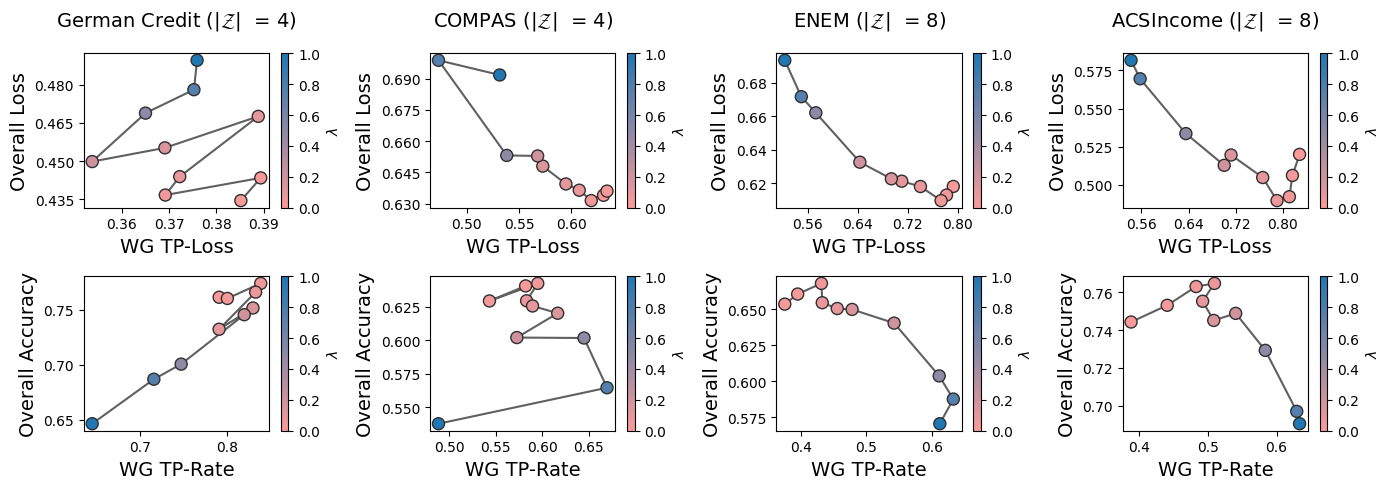

In [19]:
norm=matplotlib.colors.Normalize(0, 1)
cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#fb9a99","#1f78b4"])

fig, axs = plt.subplots(nrows = 2, ncols = 4, figsize = (14, 5))
#axs = axs.flatten()

for i, dataset in enumerate(["german_4", "compas_4", "enem_8", "acsincome_8"]):
    n_groups = int(dataset.split("_")[1])
    

    try:
        results = pd.read_csv(f"../results_aaai/experiment/fair_weight/{dataset}g/M2FGBClassifier_v1_tpr/train.csv")
        trials = pd.read_csv(f"../results_aaai/experiment/fair_weight/{dataset}g/M2FGBClassifier_v1_tpr/trials.csv")
        results = results.merge(trials)

        results["fair_weight"] = results.params_fair_weight
        #results = results[results.fair_weight < 1]
        results = results.loc[:, results.dtypes == "float"].groupby("fair_weight").mean().reset_index()

        
        # differentiable metric
        
        cm = axs[0, i].scatter(
            results.max_logloss_tpr,
            results.logloss,
            c = results.fair_weight,
            cmap = cmap,
            norm = norm,
            zorder = 100,
            s = 75,
            ec = "#303030",
        )

        axs[0, i].plot(
            results.max_logloss_tpr,
            results.logloss,
            c = "#606060",
        )

        # non-differentiable metric


        cm = axs[1, i].scatter(
            results.min_tpr,
            results.acc,
            c = results.fair_weight,
            cmap = cmap,
            norm = norm,
            zorder = 100,
            s = 75,
            ec = "#303030",
        )

        axs[1, i].plot(
            results.min_tpr,
            results.acc,
            c = "#606060",
        )

    except:
        pass 

    dataset = dataset.split("_")[0]

    axs[0, i].set_xlabel("WG TP-Loss", fontsize = 14)
    axs[0, i].set_ylabel("Overall Loss", fontsize = 14)

    axs[1, i].set_xlabel("WG TP-Rate", fontsize = 14)
    axs[1, i].set_ylabel("Overall Accuracy", fontsize = 14)

    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})", fontsize = 14, pad = 20)

    # make x and y axis only have 4 ticks each
    axs[0, i].xaxis.set_major_locator(plt.MaxNLocator(4))
    axs[0, i].yaxis.set_major_locator(plt.MaxNLocator(5))
    # add colorbar
    fig.colorbar(cm, ax=axs[0, i], label="$\lambda$")
    fig.colorbar(cm, ax=axs[1, i], label="$\lambda$")

plt.tight_layout()

plt.savefig("../figs/fair_weight.pdf", dpi = 300)
plt.show()

## Benchmark Datasets

In [4]:
import scipy.stats

def calculate_interval(samples, confidence=0.95):
    n = len(samples)
    m, se = np.mean(samples), scipy.stats.sem(samples)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return h

In [5]:
def summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    experiment_folder = "../results_aaai/experiment",
    n_sampled = 100,
    n_repetitions = 1000,
    maximize = True,
):

    alpha_list = [i/20 for i in range(21)]
    df_results = []
    
    for dataset in dataset_list:
        for model in method_list:
            try:
                results_val = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/val.csv")
                results_test = pd.read_csv(f"{experiment_folder}/{dataset}/{model}/test.csv")
                np.random.seed(SEED)
                selections = np.random.choice(len(results_val), size = (len(alpha_list), n_repetitions, n_sampled), replace = True)

                print(f"Total models for {model}, {dataset} : {len(results_val)}")
                results_val["duration"] = pd.to_timedelta(results_val["duration"]).dt.total_seconds()
                results_test["duration"] = pd.to_timedelta(results_test["duration"]).dt.total_seconds()

                for i, alpha in tqdm(enumerate(alpha_list), total = len(alpha_list)):
                    for j in range(n_repetitions):
                        # sample models
                        results_val_sample = results_val.iloc[selections[i, j]]
                        score = alpha * results_val_sample[fair_metric] + (1 - alpha) * results_val_sample[perf_metric]

                        if maximize:
                            best_model = results_test.loc[score.idxmax()]
                        else:
                            best_model = results_test.loc[score.idxmin()]

                        df_results.append({
                            "dataset" : dataset,
                            "model" : model,
                            "alpha" : alpha,
                            perf_metric : best_model[perf_metric],
                            fair_metric : best_model[fair_metric],
                            "score" : best_model[perf_metric] * (1 - alpha) + best_model[fair_metric] * alpha,
                            "duration" : best_model.duration,
                        })
            except:
               print(f"Error in {model}, {dataset}")
    df_results = pd.DataFrame(df_results)
    df_results = df_results.groupby(["dataset", "model", "alpha"]).agg({
        "duration" : ["mean", "std", calculate_interval],
        perf_metric : ["mean", "std", calculate_interval],
        fair_metric : ["mean", "std", calculate_interval],
        "score" : ["mean", "std", calculate_interval],
    }).reset_index()
    df_results.columns = ["_".join(col).strip() for col in df_results.columns.values]
    df_results = df_results.rename(columns = {
        "dataset_" : "dataset",
        "model_" : "model",
        "alpha_" : "alpha",
        "duration_mean" : "duration",
        "duration_std" : "duration_std",
        "duration_calculate_interval" : "duration_interval",
        f"{perf_metric}_mean" : f"{perf_metric}",
        f"{perf_metric}_std" : f"{perf_metric}_std",
        f"{perf_metric}_calculate_interval" : f"{perf_metric}_interval",
        f"{fair_metric}_mean" : f"{fair_metric}",
        f"{fair_metric}_std" : f"{fair_metric}_std",
        f"{fair_metric}_calculate_interval" : f"{fair_metric}_interval",
        "score_mean" : "score",
        "score_std" : "score_std",
        "score_calculate_interval" : "score_interval",})
    return df_results

In [11]:
def plot_results(axs, df_results, perf_metric, fair_metric):
    model_list = df_results.model.unique()
    for i, model in enumerate(model_list):
        df_results_filter = df_results[df_results.model == model]

        axs[0].plot(
            df_results_filter.alpha,
            df_results_filter[perf_metric],
            c = methods_color[model],
            lw = 2,
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[0].set_ylabel(perf_metric)
        axs[0].set_xlabel("alpha")

        axs[0].fill_between(
            df_results_filter.alpha,
            df_results_filter[perf_metric] - df_results_filter[perf_metric + "_interval"],
            df_results_filter[perf_metric] + df_results_filter[perf_metric + "_interval"],
            color = methods_color[model],
            alpha = 0.2,
        )


        axs[1].plot(
            df_results_filter.alpha,
            df_results_filter[fair_metric],
            lw = 2,
            c = methods_color[model],
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[1].set_ylabel(fair_metric)
        axs[1].set_xlabel("alpha")

        axs[1].fill_between(
            df_results_filter.alpha,
            df_results_filter[fair_metric] - df_results_filter[fair_metric + "_interval"],
            df_results_filter[fair_metric] + df_results_filter[fair_metric + "_interval"],
            color = methods_color[model],
            alpha = 0.2,
        )

        
        axs[2].scatter(
            df_results_filter[perf_metric],
            df_results_filter[fair_metric],
            c = methods_color[model],
            label = model,
            s = 40,
            ec = "#eeeeee",
            zorder = 100 if "M2FGB" in model else 1,
        )
        axs[2].set_xlabel(perf_metric)
        axs[2].set_ylabel(fair_metric)

    # make all ticks font size 8
    for ax in axs:
        ax.tick_params(axis='both', which='major', labelsize=8)    

## EQ Loss

In [22]:
perf_metric = "acc"
fair_metric = "min_acc"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier_v1", "LGBMClassifier",  "MinMaxFair", "FairGBMClassifier", "MinimaxPareto"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_v1, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for FairGBMClassifier, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for MinimaxPareto, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for M2FGBClassifier_v1, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.48it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for MinMaxFair, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for FairGBMClassifier, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinimaxPareto, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for M2FGBClassifier_v1, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for MinMaxFair, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for FairGBMClassifier, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinimaxPareto, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier_v1, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for MinMaxFair, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for FairGBMClassifier, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Error in MinimaxPareto, acsincome_8g


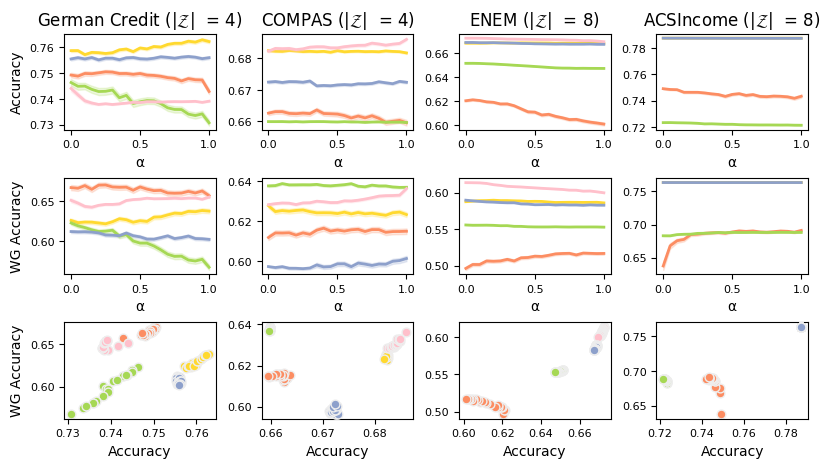

In [25]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("WG Accuracy")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("WG Accuracy")

    if i > 0:
        for j in range(3):
            axs[j, i].set_ylabel("")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)


#plt.tight_layout()
plt.savefig("../figs/bench_eq_updated.pdf", dpi = 300)

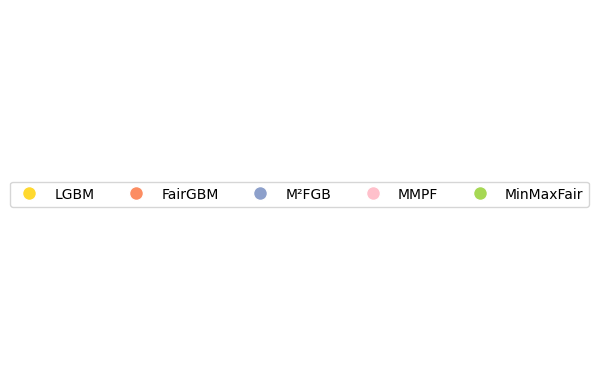

In [71]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_eq, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_eq.pdf", dpi = 300)

## PR

In [8]:
perf_metric = "acc"
fair_metric = "min_pr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier",  "LGBMClassifier"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier, german_4g : 1000


  0%|                                                    | 0/21 [00:00<?, ?it/s]

100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for M2FGBClassifier, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for M2FGBClassifier, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.49it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.48it/s]


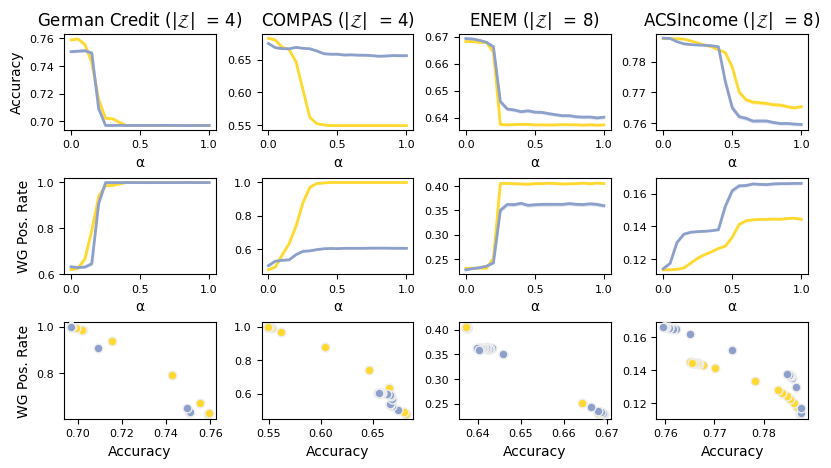

In [18]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("WG Pos. Rate")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("WG Pos. Rate")

    if i > 0:
        for j in range(3):
            axs[j, i].set_ylabel("")

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)
#plt.tight_layout()
plt.savefig("../figs/bench_pr_updated.pdf", dpi = 300)

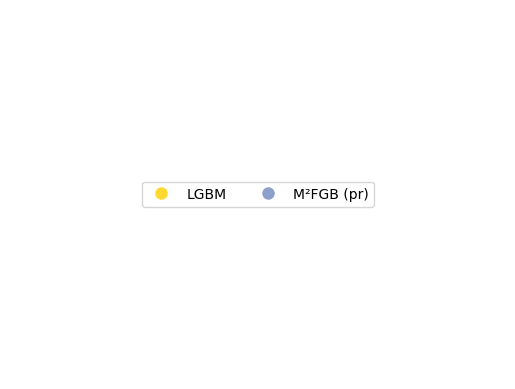

In [68]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_pr, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_pr.pdf", dpi = 300)

## TPR

In [19]:
perf_metric = "acc"
fair_metric = "min_tpr"
dataset_list = ["german_4g", "compas_4g", "enem_8g", "acsincome_8g"]
method_list = ["M2FGBClassifier_v1_tpr",  "LGBMClassifier", "MinMaxFair_tpr",  "FairGBMClassifier_eod", "MinimaxPareto_tpr"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
)

Total models for M2FGBClassifier_v1_tpr, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for LGBMClassifier, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for MinMaxFair_tpr, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for FairGBMClassifier_eod, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinimaxPareto_tpr, german_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier_v1_tpr, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for LGBMClassifier, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinMaxFair_tpr, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for FairGBMClassifier_eod, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.42it/s]


Total models for MinimaxPareto_tpr, compas_4g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for M2FGBClassifier_v1_tpr, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for LGBMClassifier, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.44it/s]


Total models for MinMaxFair_tpr, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for FairGBMClassifier_eod, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for MinimaxPareto_tpr, enem_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.45it/s]


Total models for M2FGBClassifier_v1_tpr, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.47it/s]


Total models for LGBMClassifier, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.46it/s]


Total models for MinMaxFair_tpr, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for FairGBMClassifier_eod, acsincome_8g : 500


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Error in MinimaxPareto_tpr, acsincome_8g


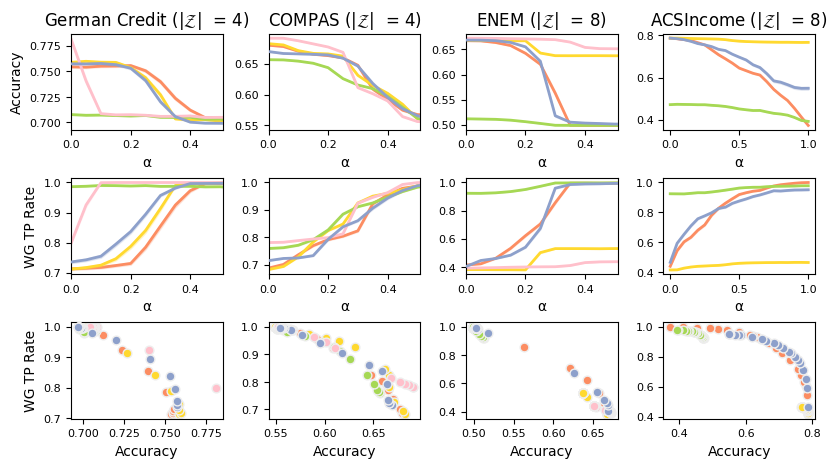

In [21]:
fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (2.4 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results[df_results.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(2):
        axs[j, i].set_xlabel("α")
        #axs[j, i].set_xlim(0, 0.7)
    axs[0, i].set_ylabel("Accuracy")
    axs[1, i].set_ylabel("WG TP Rate")

    axs[2, i].set_xlabel("Accuracy")
    axs[2, i].set_ylabel("WG TP Rate")

    if i > 0:
        for j in range(3):
            axs[j, i].set_ylabel("")    


for i in range(2):
    axs[i, 0].set_xlim(0, 0.51)
    axs[i, 1].set_xlim(0, 0.51)
    axs[i, 2].set_xlim(0, 0.51)


#plt.tight_layout()

plt.subplots_adjust(hspace=0.5)
plt.subplots_adjust(wspace=0.3)

plt.savefig("../figs/bench_tpr_updated.pdf", dpi = 300)

### Computing Cost

In [42]:
computing_cost = df_results[df_results.alpha == .0]
for dataset in dataset_list:
    print(dataset)
    baseline = computing_cost.loc[(computing_cost.dataset == dataset) & (computing_cost.model == "LGBMClassifier"), "duration"].values[0]
    for method in method_list:
        try:
        
            method_duration = computing_cost.loc[(computing_cost.dataset == dataset) & (computing_cost.model == method), "duration"].values[0]
            print(f"{method} : {np.round(method_duration / baseline, 1)}")
        except:
            pass

    print("\n")

german_4g
M2FGBClassifier_v1_tpr : 4.1
LGBMClassifier : 1.0
MinMaxFair_tpr : 15.6
FairGBMClassifier_eod : 0.9
MinimaxPareto_tpr : 27.8


compas_4g
M2FGBClassifier_v1_tpr : 2.4
LGBMClassifier : 1.0
MinMaxFair_tpr : 42.1
FairGBMClassifier_eod : 2.2
MinimaxPareto_tpr : 19.1


enem_8g
M2FGBClassifier_v1_tpr : 1.7
LGBMClassifier : 1.0
MinMaxFair_tpr : 11.9
FairGBMClassifier_eod : 0.6
MinimaxPareto_tpr : 11.4


acsincome_8g
M2FGBClassifier_v1_tpr : 2.3
LGBMClassifier : 1.0
MinMaxFair_tpr : 24.0
FairGBMClassifier_eod : 1.0




### Plots

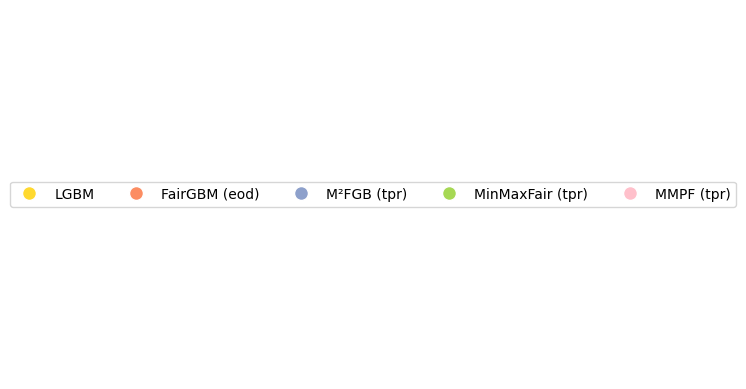

In [43]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_tpr, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_tpr.pdf", dpi = 300)

### MSE

In [26]:
perf_metric = "mse"
fair_metric = "max_mse"
dataset_list = ["enemreg_8g"]
method_list = ["M2FGBRegressor", "LGBMRegressor", "MinMaxFairRegressor"]
df_results = summary_experiment(
    perf_metric,
    fair_metric,
    dataset_list,
    method_list,
    maximize=False,
)

Total models for M2FGBRegressor, enemreg_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.43it/s]


Total models for LGBMRegressor, enemreg_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.41it/s]


Total models for MinMaxFairRegressor, enemreg_8g : 1000


100%|███████████████████████████████████████████| 21/21 [00:14<00:00,  1.40it/s]


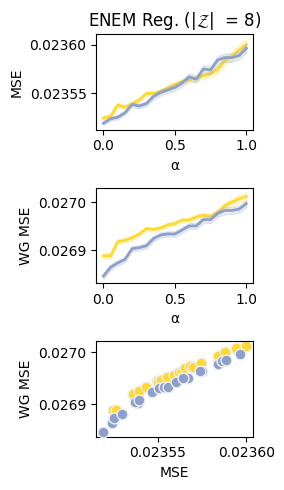

In [46]:
df_results_temp = df_results[df_results.model != "MinMaxFairRegressor"]


fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results_temp[df_results_temp.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("MSE")
    axs[1, i].set_ylabel("WG MSE")

    axs[2, i].set_xlabel("MSE")
    axs[2, i].set_ylabel("WG MSE")
plt.tight_layout()
plt.savefig("../figs/bench_mse_v1.pdf", dpi = 300)

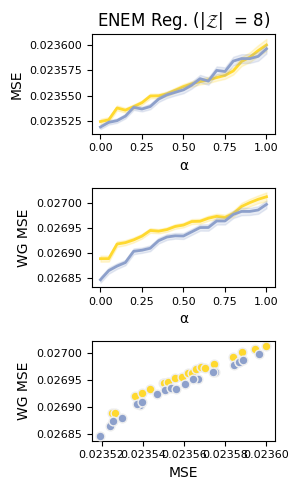

In [28]:
df_results_temp = df_results[df_results.model != "MinMaxFairRegressor"]


fig, axs = plt.subplots(nrows = 3, ncols = len(dataset_list), figsize = (3 * len(dataset_list), 5))
if len(dataset_list) == 1:
    axs = np.array(axs).reshape(-1, 1)

for i, dataset in enumerate(dataset_list):
    plot_results(axs[:, i], df_results_temp[df_results_temp.dataset == dataset], perf_metric, fair_metric)
    n_groups = int(dataset.split("_")[1][:-1])
    dataset = dataset.split("_")[0]
    axs[0, i].set_title(dataset_names[dataset] + " (|$\mathcal{Z}$|  " + f"= {n_groups})")
    for j in range(3):
        axs[j, i].set_xlabel("α")
    axs[0, i].set_ylabel("MSE")
    axs[1, i].set_ylabel("WG MSE")

    axs[2, i].set_xlabel("MSE")
    axs[2, i].set_ylabel("WG MSE")

    
plt.tight_layout()
plt.savefig("../figs/bench_mse_updated.pdf", dpi = 300)

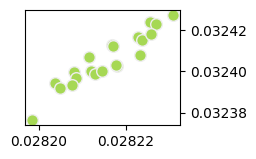

In [47]:
df_results_mmfair = df_results.copy()
df_results_mmfair = df_results_mmfair[df_results_mmfair.model == "MinMaxFairRegressor"]

fig, ax = plt.subplots(figsize = (2, 1.5))

ax.scatter(
    df_results_mmfair[perf_metric],
    df_results_mmfair[fair_metric],
    c = methods_color["MinMaxFairRegressor"],
    s = 70,
    ec = "#eeeeee",
)
ax.yaxis.tick_right()
plt.savefig("../figs/bench_mse_v2.pdf", dpi = 300)

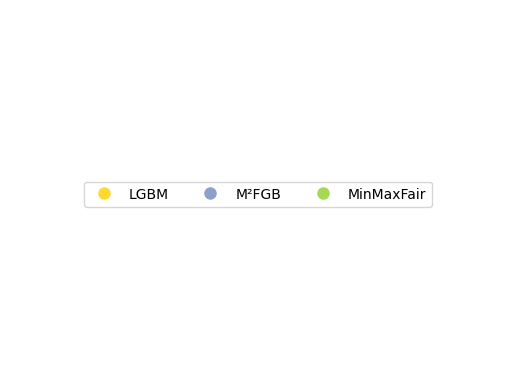

In [48]:
# plot the legend separately
fig, ax = plt.subplots()
ax.legend(handles = handles_reg, loc = "center", ncol = len(handles_tpr), fontsize = 10)
ax.axis("off")
plt.savefig("../figs/legend_reg.pdf", dpi = 300)